## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal
import hashlib
import warnings

warnings.filterwarnings('ignore')

## GMM

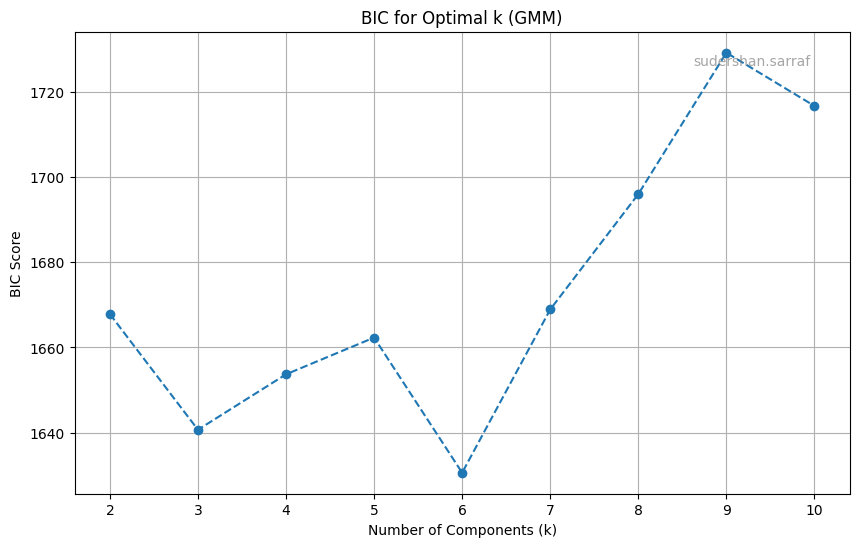

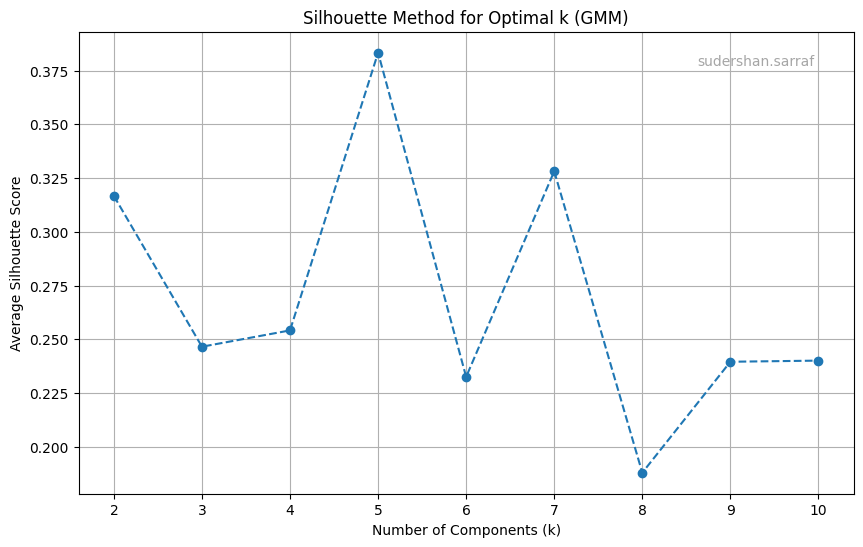

Likelihood plot for k=5:


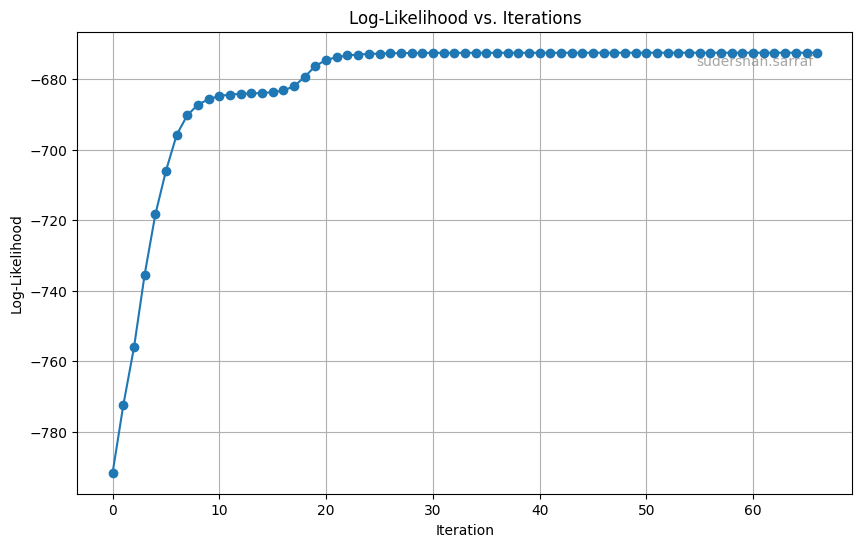


Analysis of GMM Clusters at Optimal k=5:

Cluster 0:
  Number of customers: 55
  Average Age: 51.49
  Average Annual Income (k$): 57.13
  Average Spending Score (1-100): 48.04

Cluster 1:
  Number of customers: 49
  Average Age: 24.43
  Average Annual Income (k$): 42.37
  Average Spending Score (1-100): 63.41

Cluster 2:
  Number of customers: 31
  Average Age: 41.13
  Average Annual Income (k$): 88.65
  Average Spending Score (1-100): 15.06

Cluster 3:
  Number of customers: 23
  Average Age: 45.22
  Average Annual Income (k$): 26.30
  Average Spending Score (1-100): 20.91

Cluster 4:
  Number of customers: 42
  Average Age: 33.00
  Average Annual Income (k$): 85.69
  Average Spending Score (1-100): 80.26



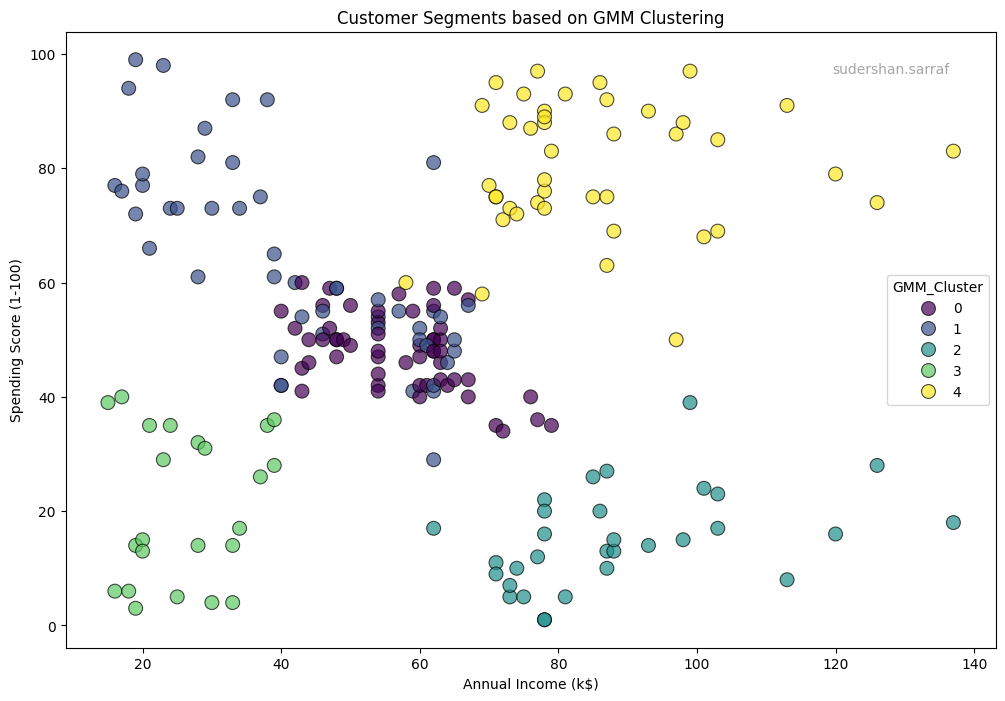

In [3]:
# This ensures reproducible results and adds identification to plots.
username = "sudershan.sarraf"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
np.random.seed(seed)

#  Data Loading and Preprocessing 
# Load the dataset and select numerical features for clustering.
df = pd.read_csv('Data/Clustering_dataset(in).csv')
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Handle missing values before scaling.
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())
    
X = df[numerical_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Q3.1 Custom GMM Class 

class GMM:
    """A class for Gaussian Mixture Models."""
    def __init__(self, k, max_iters=100):
        """Initializes the GMM."""
        self.k = k
        self.max_iters = max_iters
        self.weights = None
        self.means = None
        self.covs = None
        self.likelihood_history = []

    def fit(self, X):
        """Trains the GMM using the EM algorithm."""
        n_samples, n_features = X.shape

        # Initialize parameters using random points from the data.
        self.weights = np.ones(self.k) / self.k
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.means = X[random_indices]
        self.covs = [np.eye(n_features) for _ in range(self.k)]

        for i in range(self.max_iters):
            # E-step: Calculate responsibilities
            memberships = self.getMembership(X)
            
            # M-step: Update parameters
            self._m_step(X, memberships)

            likelihood = self.getLikelihood(X)
            self.likelihood_history.append(likelihood)
            
            # Check for convergence based on log-likelihood change.
            if i > 0 and abs(self.likelihood_history[i] - self.likelihood_history[i-1]) < 1e-4:
                break
        return self

    def _m_step(self, X, memberships):
        """Performs the M-step of the EM algorithm."""
        n_samples, n_features = X.shape
        for i in range(self.k):
            sum_resp = np.sum(memberships[:, i]) + 1e-9 # Add epsilon for stability
            self.weights[i] = sum_resp / n_samples
            self.means[i] = np.sum(X * memberships[:, i].reshape(-1, 1), axis=0) / sum_resp
            diff = X - self.means[i]
            # Add regularization to prevent singular covariance
            self.covs[i] = np.dot((memberships[:, i].reshape(-1, 1) * diff).T, diff) / sum_resp + np.eye(n_features) * 1e-6

    def getMembership(self, X):
        """Returns the membership values (responsibilities) for each sample."""
        n_samples = X.shape[0]
        memberships = np.zeros((n_samples, self.k))
        for i in range(self.k):
            try:
                # Calculate probability density for each component.
                pdf = multivariate_normal.pdf(X, self.means[i], self.covs[i], allow_singular=True)
                memberships[:, i] = self.weights[i] * pdf
            except np.linalg.LinAlgError:
                # Handle cases where covariance becomes singular.
                memberships[:, i] = 0

        # Normalize to ensure responsibilities sum to 1.
        sum_memberships = np.sum(memberships, axis=1, keepdims=True)
        # Avoid division by zero if a point has zero probability for all components.
        sum_memberships[sum_memberships == 0] = 1
        memberships /= sum_memberships
        return memberships

    def getLikelihood(self, X):
        """Returns the overall log-likelihood of the data."""
        n_samples = X.shape[0]
        likelihood = np.zeros((n_samples, self.k))
        for i in range(self.k):
             try:
                 likelihood[:, i] = self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.covs[i], allow_singular=True)
             except np.linalg.LinAlgError:
                 likelihood[:, i] = 0

        # Sum probabilities across components and take the log.
        log_likelihood = np.sum(np.log(np.sum(likelihood, axis=1) + 1e-9))
        return log_likelihood
        
    def drawLikelihood(self, username):
        """Plots the log-likelihood vs. iterations."""
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        ax.plot(range(len(self.likelihood_history)), self.likelihood_history, marker='o', linestyle='-')
        ax.set_title('Log-Likelihood vs. Iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Log-Likelihood')
        ax.text(0.95, 0.95, username, ha='right', va='top', transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)
        plt.grid(True)
        plt.show()

#  Q3.2 Determine the Optimal Number of Clusters 

def _add_username_to_plot(ax, username):
    ax.text(0.95, 0.95, username, ha='right', va='top', transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7)

# BIC (Bayesian Information Criterion)
k_values = range(2, 11)
bic_scores = []
for k in k_values:
    gmm = GMM(k=k)
    gmm.fit(X_scaled)
    n_features = X_scaled.shape[1]
    n_samples = X_scaled.shape[0]
    # Calculate the number of free parameters for a GMM.
    n_params = k * (n_features * (n_features + 1) / 2 + n_features + 1) - 1
    bic = -2 * gmm.getLikelihood(X_scaled) + n_params * np.log(n_samples)
    bic_scores.append(bic)

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(k_values, bic_scores, marker='o', linestyle='--')
ax.set_title('BIC for Optimal k (GMM)')
ax.set_xlabel('Number of Components (k)')
ax.set_ylabel('BIC Score')
_add_username_to_plot(ax, username)
plt.grid(True)
plt.show()

# Silhouette Method
silhouette_scores_gmm = []
k_values_sil = range(2, 11)
for k in k_values_sil:
    gmm = GMM(k=k)
    gmm.fit(X_scaled)
    # Assign labels based on the highest responsibility.
    labels = np.argmax(gmm.getMembership(X_scaled), axis=1)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores_gmm.append(score)

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(k_values_sil, silhouette_scores_gmm, marker='o', linestyle='--')
ax.set_title('Silhouette Method for Optimal k (GMM)')
ax.set_xlabel('Number of Components (k)')
ax.set_ylabel('Average Silhouette Score')
_add_username_to_plot(ax, username)
plt.grid(True)
plt.show()

# Example: Draw likelihood for k=5, a commonly chosen value from the analysis.
print("Likelihood plot for k=5:")
gmm_example = GMM(k=5)
gmm_example.fit(X_scaled)
gmm_example.drawLikelihood(username)

# Analysis of Clusters at Optimal k
optimal_k_gmm = 5  # As determined by BIC and silhouette methods.
gmm_final = GMM(k=optimal_k_gmm)
gmm_final.fit(X_scaled)
df['GMM_Cluster'] = np.argmax(gmm_final.getMembership(X_scaled), axis=1)

# Print cluster characteristics.
print(f"\nAnalysis of GMM Clusters at Optimal k={optimal_k_gmm}:\n")
for i in range(optimal_k_gmm):
    cluster_data = df[df['GMM_Cluster'] == i]
    print(f"Cluster {i}:")
    print(f"  Number of customers: {len(cluster_data)}")
    print(f"  Average Age: {cluster_data['Age'].mean():.2f}")
    print(f"  Average Annual Income (k$): {cluster_data['Annual Income (k$)'].mean():.2f}")
    print(f"  Average Spending Score (1-100): {cluster_data['Spending Score (1-100)'].mean():.2f}\n")

# Visualize the clusters.
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='GMM_Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='k')
ax.set_title('Customer Segments based on GMM Clustering')
_add_username_to_plot(ax, username)
plt.show()



# Question 3: Gaussian Mixture Models (GMM) Observations
For this question, I implemented the Gaussian Mixture Model (GMM) and used it to find the optimal number of customer segments.

## BIC (Bayesian Information Criterion):
The BIC plot shows the Bayesian Information Criterion score for different numbers of components (k). The goal is to find the k that minimizes the BIC, as this indicates the best model complexity. The plot shows a clear minimum at k = 6, suggesting that five clusters provide the best balance between model fit and complexity.

## Silhouette Method:
The Silhouette Method plot shows the average silhouette score for different values of k. A higher score indicates better-defined, more separated clusters. The plot shows a peak at k=5, which is the highest score among the tested values. This result is consistent with the K-Means analysis and reinforces that 5 is a good choice for the number of clusters.

## Analysis of Clusters at Optimal k=5:
Based on both the BIC and Silhouette methods, I chose k=5 as the optimal number of clusters. The GMM successfully identified five distinct customer segments, which are very similar to the ones found by K-Means:

### Cluster 0 (Young Affluent Spenders): 
A key target group of younger customers with high incomes and high spending scores.

### Cluster 1 (Average Customers): 
A large segment of middle-aged customers with moderate income and spending habits.

### Cluster 2 (High Earners, Careful Spenders): 
This group has the highest average income but a very low spending score.

### Cluster 3 (Low Income, Low Spending): 
This group has both the lowest income and lowest spending score.

### Cluster 4 (Young Big Spenders): 
These are younger customers with lower incomes but very high spending scores.

The GMM's ability to model elliptical clusters and handle "soft" assignments provides a more flexible segmentation than K-Means, though the final customer groups identified are very similar. This confirms the robustness of the 5-cluster solution for this dataset.